In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaModel,
    RobertaTokenizer,
    get_linear_schedule_with_warmup
)
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import logging
from typing import List, Dict, Tuple, Optional
import random
from dataclasses import dataclass

In [2]:
from torch.optim import AdamW

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [5]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Check token length

In [ ]:
# I should do it only on the train set, but for simplicity for now it is on all the data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

with open("/content/drive/My Drive/text_processing/sport_headlines_20K.json", "r") as f:
    headlines = json.load(f)

lengths = [len(tokenizer.tokenize(headline)) for headline in headlines[:2000]]
print(f"Average length: {np.mean(lengths):.1f}")
print(f"95th percentile: {np.percentile(lengths, 95):.0f}")
print(f"Max length: {max(lengths)}")

Average length: 9.8
95th percentile: 14
Max length: 19


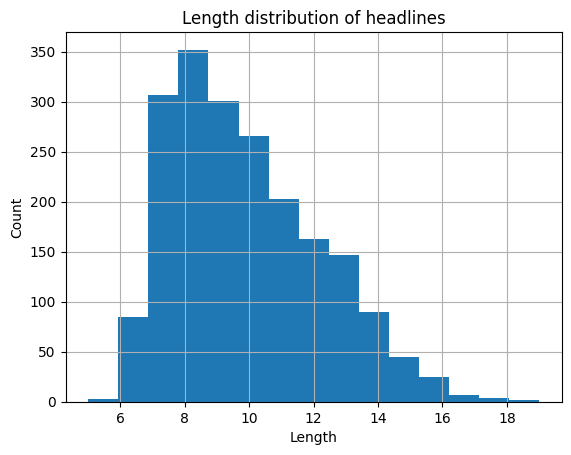

In [ ]:
plt.hist(lengths, bins=15)
plt.grid()
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Length distribution of headlines")
plt.show()

**Taking a max length of 16.**

# Definitions

In [6]:
@dataclass
class SimCSEConfig:
    """Configuration class for SimCSE fine-tuning"""
    # Model parameters
    model_name: str = "roberta-base"
    max_length: int = 16
    pooler_type: str = "cls"  # cls, cls_before_pooler, avg, avg_top2, avg_first_last
    use_mlp_for_all_pooling: bool = True
    temp: float = 0.36  # Temperature for contrastive learning

    # Training parameters
    batch_size: int = 256
    learning_rate: float = 3e-5
    num_epochs: int = 1
    warmup_ratio: float = 0.1
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0

    # Data parameters
    train_ratio: float = 0.8
    val_ratio: float = 0.1
    test_ratio: float = 0.1
    random_seed: int = 42

    # Evaluation parameters
    eval_steps: int = 16
    save_steps: int = 30

    # Paths
    data_path: str = "/content/drive/My Drive/text_processing/sport_headlines_20K.json"
    output_dir: str = "/content/drive/My Drive/text_processing/SimCSE/simcse_finetuned_model"
    test_file: str = "/content/drive/My Drive/text_processing/SimCSE/sport_headlines_test_set.json"

In [7]:
class SimCSEDataset(Dataset):
    """Dataset for SimCSE unsupervised training"""

    def __init__(self, sentences: List[str], tokenizer, max_length: int = 16):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        # Tokenize the sentence
        encoded = self.tokenizer(
            sentence,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
        }

In [8]:
class SimCSEModel(nn.Module):
    """SimCSE model for unsupervised sentence embeddings"""

    def __init__(self, config: SimCSEConfig):
        super(SimCSEModel, self).__init__()
        self.config = config
        self.roberta = RobertaModel.from_pretrained(config.model_name)
        self.pooler_type = config.pooler_type

        # Add MLP layer based on use_mlp_for_all_pooling config
        if config.use_mlp_for_all_pooling:
            self.mlp = nn.Sequential(
                nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size),
                nn.Tanh()
            )
        else:
            self.mlp = None

    def forward(self, input_ids, attention_mask, output_hidden_states=False):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=output_hidden_states,
            return_dict=True
        )

        # Pool the representations
        pooled = self.pooling(outputs, attention_mask)

        if output_hidden_states:
            return pooled, outputs.hidden_states

        # The size of the returned tensor is [batch size, hidden state],
        # So per sample I have the RoBERTa vector returned
        return pooled

    def pooling(self, outputs, attention_mask):
        """Apply pooling strategy to get sentence embeddings"""
        last_hidden = outputs.last_hidden_state
        hidden_states = outputs.hidden_states

        if self.pooler_type == "cls":
            # Use [CLS] token representation AFTER pooler
            pooled = self.roberta.pooler(last_hidden)  # Goes through BERT's pooler layer

        elif self.pooler_type == "cls_before_pooler":
            # Use [CLS] token representation BEFORE pooler (raw)
            pooled = last_hidden[:, 0]  # Direct [CLS] token, no pooler layer

        elif self.pooler_type == "avg":
            # Average pooling over all tokens
            pooled = ((last_hidden * attention_mask.unsqueeze(-1)).sum(1) /
                     attention_mask.sum(-1).unsqueeze(-1))

        elif self.pooler_type == "avg_top2":
            # Average pooling of top 2 layers
            second_last_hidden = hidden_states[-2]
            pooled = ((last_hidden + second_last_hidden) / 2.0 *
                     attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(-1).unsqueeze(-1)

        elif self.pooler_type == "avg_first_last":
            # Average pooling of first and last layers
            first_hidden = hidden_states[1]  # Skip embedding layer
            pooled = ((first_hidden + last_hidden) / 2.0 *
                     attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(-1).unsqueeze(-1)

        else:
            raise NotImplementedError(f"Pooler type {self.pooler_type} not implemented")

        # Apply MLP if configured (regardless of pooling type)
        if self.mlp is not None:
            pooled = self.mlp(pooled)

        return pooled

In [9]:
class SimCSETrainer:
    """Trainer for SimCSE model"""

    def __init__(self, config: SimCSEConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        # Set random seeds
        self.set_seed(config.random_seed)

        # Initialize tokenizer and model
        self.tokenizer = RobertaTokenizer.from_pretrained(config.model_name)
        self.model = SimCSEModel(config).to(self.device)

        # Create output directory
        os.makedirs(config.output_dir, exist_ok=True)

    def set_seed(self, seed: int):
        """Set random seed for reproducibility"""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    def load_and_split_data(self) -> Tuple[List[str], List[str], List[str]]:
        """Load data and split into train/val/test sets"""
        logger.info(f"Loading data from {self.config.data_path}")

        with open(self.config.data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if isinstance(data, list):
            sentences = data
        elif isinstance(data, dict):
            # Assume the sentences are in a key like 'sentences' or take all values
            if 'sentences' in data:
                sentences = data['sentences']
            else:
                sentences = list(data.values())
        else:
            raise ValueError("Data format not supported")

        logger.info(f"Total sentences: {len(sentences)}")

        # First split: train+val vs test
        train_val, test = train_test_split(
            sentences,
            test_size=self.config.test_ratio,
            random_state=self.config.random_seed
        )

        # Second split: train vs val
        val_size = self.config.val_ratio / (self.config.train_ratio + self.config.val_ratio)
        train, val = train_test_split(
            train_val,
            test_size=val_size,
            random_state=self.config.random_seed
        )

        # Save test set for later examination
        test_file_path = os.path.join(self.config.output_dir, self.config.test_file)
        with open(test_file_path, 'w', encoding='utf-8') as f:
            json.dump(test, f, indent=2, ensure_ascii=False)

        logger.info(f"Data split - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
        logger.info(f"Test set saved to: {test_file_path}")

        return train, val, test

    def create_dataloaders(self, train_sentences: List[str], val_sentences: List[str]) -> Tuple[DataLoader, DataLoader]:
        """Create training and validation dataloaders"""
        train_dataset = SimCSEDataset(train_sentences, self.tokenizer, self.config.max_length)
        val_dataset = SimCSEDataset(val_sentences, self.tokenizer, self.config.max_length)

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        return train_loader, val_loader

    def contrastive_loss(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> torch.Tensor:
        """Compute contrastive loss between two sets of embeddings"""
        # Normalize embeddings
        embeddings1 = F.normalize(embeddings1, dim=1)
        embeddings2 = F.normalize(embeddings2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(embeddings1, embeddings2.T) / self.config.temp

        # Labels are diagonal (positive pairs)
        batch_size = embeddings1.size(0)
        labels = torch.arange(batch_size).to(self.device)

        # Compute cross-entropy loss
        loss = F.cross_entropy(sim_matrix, labels)

        return loss

    def train_step(self, batch) -> float:
        """Perform a single training step"""
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)

        # Forward pass with different dropout masks
        embeddings1 = self.model(input_ids, attention_mask)
        embeddings2 = self.model(input_ids, attention_mask)

        # Compute contrastive loss
        loss = self.contrastive_loss(embeddings1, embeddings2)

        return loss

    def validate(self, val_loader: DataLoader) -> float:
        """Perform validation"""
        self.model.eval()
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                loss = self.train_step(batch)
                total_loss += loss.item()
                num_batches += 1

        avg_loss = total_loss / num_batches
        return avg_loss

    def save_model(self, epoch: int, step: int, loss: float):
        """Save model checkpoint"""
        try:
            checkpoint = {
                'epoch': epoch,
                'step': step,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': loss,
                'config': self.config
            }

            checkpoint_path = os.path.join(self.config.output_dir, f'checkpoint-{step}.pt')

            torch.save(checkpoint, checkpoint_path)
            print(f"DEBUG: torch.save completed successfully")

            # Save tokenizer
            self.tokenizer.save_pretrained(self.config.output_dir)

            # Save model config
            config_path = os.path.join(self.config.output_dir, 'training_config.json')
            with open(config_path, 'w') as f:
                json.dump(self.config.__dict__, f, indent=2)

        except Exception as e:
            print(f"ERROR in save_model: {e}")
            import traceback
            traceback.print_exc()


    def train(self):
        """Main training loop"""
        logger.info("Starting training...")

        # Load and split data
        train_sentences, val_sentences, _ = self.load_and_split_data()

        # Create dataloaders
        train_loader, val_loader = self.create_dataloaders(train_sentences, val_sentences)

        # Calculate total steps
        total_steps = len(train_loader) * self.config.num_epochs
        warmup_steps = int(total_steps * self.config.warmup_ratio)

        # Initialize optimizer and scheduler
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        logger.info(f"Total steps: {total_steps}, Warmup steps: {warmup_steps}")

        # Training loop
        global_step = 0
        best_val_loss = float('inf')

        for epoch in range(self.config.num_epochs):
            self.model.train()
            epoch_loss = 0.0
            num_batches = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs}")

            for batch in progress_bar:
                # Forward pass
                loss = self.train_step(batch)

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)

                # Update parameters
                self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad()

                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1
                global_step += 1

                # Update progress bar
                progress_bar.set_postfix({
                    'batch_loss': f'{loss.item():.4f}',
                    'epoch_avg': f'{epoch_loss / num_batches:.4f}',
                    'lr': f'{self.scheduler.get_last_lr()[0]:.1e}',
                    'step': global_step
                })

                print(f"DEBUG: global_step={global_step}, eval_steps={self.config.eval_steps}, modulo={global_step % self.config.eval_steps}")

                # Validation and saving
                if global_step % self.config.eval_steps == 0:
                    print("VALIDATION")
                    val_loss = self.validate(val_loader)
                    print("Val Loss", val_loss)

                    logger.info(f"Step {global_step}: Train Loss = {epoch_loss/num_batches:.4f}, Val Loss = {val_loss:.4f}")

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        logger.info(f"New best validation loss: {val_loss:.4f}")
                    else:
                        print(f"DEBUG: No improvement. {val_loss:.4f} >= {best_val_loss:.4f}")

                    self.model.train()

            # End of epoch validation


            # After the training loop ends:
            val_loss = self.validate(val_loader)
            logger.info(f"Epoch {epoch+1} Final Results:")
            logger.info(f"  Train Loss: {epoch_loss / num_batches:.4f}")
            logger.info(f"  Val Loss: {val_loss:.4f}")

        # Final save
        self.save_model(self.config.num_epochs - 1, global_step, val_loss)
        logger.info("Training completed!")

In [10]:
config = SimCSEConfig()  # Uses all defaults
# # Modify only what you need:
# config.num_epochs = 2
# config.output_dir = "/content/drive/My Drive/text_processing/SimCSE/simcse_finetuned_model_2"
# config.test_file = "/content/drive/My Drive/text_processing/SimCSE/sport_headlines_test_set_2.json"

In [11]:
config

SimCSEConfig(model_name='roberta-base', max_length=16, pooler_type='cls', use_mlp_for_all_pooling=True, temp=0.36, batch_size=256, learning_rate=3e-05, num_epochs=1, warmup_ratio=0.1, weight_decay=0.01, max_grad_norm=1.0, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42, eval_steps=16, save_steps=30, data_path='/content/drive/My Drive/text_processing/sport_headlines_20K.json', output_dir='/content/drive/My Drive/text_processing/SimCSE/simcse_finetuned_model', test_file='/content/drive/My Drive/text_processing/SimCSE/sport_headlines_test_set.json')

# Model Training

In [12]:
trainer = SimCSETrainer(config)

INFO:__main__:Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Start training
trainer.train()

INFO:__main__:Starting training...
INFO:__main__:Loading data from /content/drive/My Drive/text_processing/sport_headlines_20K.json
INFO:__main__:Total sentences: 20000
INFO:__main__:Data split - Train: 15999, Val: 2001, Test: 2000
INFO:__main__:Test set saved to: /content/drive/My Drive/text_processing/SimCSE/sport_headlines_test_set.json
INFO:__main__:Total steps: 63, Warmup steps: 6
Epoch 1/1:   2%|▏         | 1/63 [00:03<03:22,  3.27s/it, batch_loss=5.5450, epoch_avg=5.5450, lr=5.0e-06, step=1]

DEBUG: global_step=1, eval_steps=16, modulo=1


Epoch 1/1:   3%|▎         | 2/63 [00:04<02:09,  2.13s/it, batch_loss=5.5444, epoch_avg=5.5447, lr=1.0e-05, step=2]

DEBUG: global_step=2, eval_steps=16, modulo=2


Epoch 1/1:   5%|▍         | 3/63 [00:05<01:42,  1.71s/it, batch_loss=5.5445, epoch_avg=5.5446, lr=1.5e-05, step=3]

DEBUG: global_step=3, eval_steps=16, modulo=3


Epoch 1/1:   6%|▋         | 4/63 [00:07<01:29,  1.51s/it, batch_loss=5.5422, epoch_avg=5.5440, lr=2.0e-05, step=4]

DEBUG: global_step=4, eval_steps=16, modulo=4


Epoch 1/1:   8%|▊         | 5/63 [00:08<01:22,  1.42s/it, batch_loss=5.5315, epoch_avg=5.5415, lr=2.5e-05, step=5]

DEBUG: global_step=5, eval_steps=16, modulo=5


Epoch 1/1:  10%|▉         | 6/63 [00:09<01:17,  1.36s/it, batch_loss=5.5142, epoch_avg=5.5369, lr=3.0e-05, step=6]

DEBUG: global_step=6, eval_steps=16, modulo=6


Epoch 1/1:  11%|█         | 7/63 [00:10<01:13,  1.32s/it, batch_loss=5.4619, epoch_avg=5.5262, lr=2.9e-05, step=7]

DEBUG: global_step=7, eval_steps=16, modulo=7


Epoch 1/1:  13%|█▎        | 8/63 [00:11<01:10,  1.29s/it, batch_loss=5.3471, epoch_avg=5.5038, lr=2.9e-05, step=8]

DEBUG: global_step=8, eval_steps=16, modulo=8


Epoch 1/1:  14%|█▍        | 9/63 [00:13<01:08,  1.27s/it, batch_loss=5.1390, epoch_avg=5.4633, lr=2.8e-05, step=9]

DEBUG: global_step=9, eval_steps=16, modulo=9


Epoch 1/1:  16%|█▌        | 10/63 [00:14<01:06,  1.26s/it, batch_loss=4.8768, epoch_avg=5.4046, lr=2.8e-05, step=10]

DEBUG: global_step=10, eval_steps=16, modulo=10


Epoch 1/1:  17%|█▋        | 11/63 [00:15<01:04,  1.25s/it, batch_loss=4.5943, epoch_avg=5.3310, lr=2.7e-05, step=11]

DEBUG: global_step=11, eval_steps=16, modulo=11


Epoch 1/1:  19%|█▉        | 12/63 [00:16<01:03,  1.24s/it, batch_loss=4.4095, epoch_avg=5.2542, lr=2.7e-05, step=12]

DEBUG: global_step=12, eval_steps=16, modulo=12


Epoch 1/1:  21%|██        | 13/63 [00:18<01:01,  1.24s/it, batch_loss=4.2810, epoch_avg=5.1793, lr=2.6e-05, step=13]

DEBUG: global_step=13, eval_steps=16, modulo=13


Epoch 1/1:  22%|██▏       | 14/63 [00:19<01:00,  1.24s/it, batch_loss=4.2073, epoch_avg=5.1099, lr=2.6e-05, step=14]

DEBUG: global_step=14, eval_steps=16, modulo=14


Epoch 1/1:  24%|██▍       | 15/63 [00:20<00:59,  1.25s/it, batch_loss=4.1353, epoch_avg=5.0449, lr=2.5e-05, step=15]

DEBUG: global_step=15, eval_steps=16, modulo=15


Epoch 1/1:  24%|██▍       | 15/63 [00:21<00:59,  1.25s/it, batch_loss=4.0981, epoch_avg=4.9857, lr=2.5e-05, step=16]

DEBUG: global_step=16, eval_steps=16, modulo=0
VALIDATION



Validating: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]
INFO:__main__:Step 16: Train Loss = 4.9857, Val Loss = 3.7730
INFO:__main__:New best validation loss: 3.7730
Epoch 1/1:  25%|██▌       | 16/63 [00:25<01:46,  2.28s/it, batch_loss=4.0981, epoch_avg=4.9857, lr=2.5e-05, step=16]

Val Loss 3.7730119824409485


Epoch 1/1:  27%|██▋       | 17/63 [00:26<01:30,  1.97s/it, batch_loss=4.0311, epoch_avg=4.9296, lr=2.4e-05, step=17]

DEBUG: global_step=17, eval_steps=16, modulo=1


Epoch 1/1:  29%|██▊       | 18/63 [00:27<01:18,  1.75s/it, batch_loss=3.9928, epoch_avg=4.8775, lr=2.4e-05, step=18]

DEBUG: global_step=18, eval_steps=16, modulo=2


Epoch 1/1:  30%|███       | 19/63 [00:29<01:10,  1.60s/it, batch_loss=3.9484, epoch_avg=4.8286, lr=2.3e-05, step=19]

DEBUG: global_step=19, eval_steps=16, modulo=3


Epoch 1/1:  32%|███▏      | 20/63 [00:30<01:04,  1.49s/it, batch_loss=3.8887, epoch_avg=4.7816, lr=2.3e-05, step=20]

DEBUG: global_step=20, eval_steps=16, modulo=4


Epoch 1/1:  33%|███▎      | 21/63 [00:31<00:59,  1.42s/it, batch_loss=3.8113, epoch_avg=4.7354, lr=2.2e-05, step=21]

DEBUG: global_step=21, eval_steps=16, modulo=5


Epoch 1/1:  35%|███▍      | 22/63 [00:32<00:56,  1.37s/it, batch_loss=3.7843, epoch_avg=4.6922, lr=2.2e-05, step=22]

DEBUG: global_step=22, eval_steps=16, modulo=6


Epoch 1/1:  37%|███▋      | 23/63 [00:34<00:53,  1.35s/it, batch_loss=3.7458, epoch_avg=4.6511, lr=2.1e-05, step=23]

DEBUG: global_step=23, eval_steps=16, modulo=7


Epoch 1/1:  38%|███▊      | 24/63 [00:35<00:51,  1.33s/it, batch_loss=3.7033, epoch_avg=4.6116, lr=2.1e-05, step=24]

DEBUG: global_step=24, eval_steps=16, modulo=8


Epoch 1/1:  40%|███▉      | 25/63 [00:36<00:49,  1.31s/it, batch_loss=3.6882, epoch_avg=4.5746, lr=2.0e-05, step=25]

DEBUG: global_step=25, eval_steps=16, modulo=9


Epoch 1/1:  41%|████▏     | 26/63 [00:37<00:47,  1.29s/it, batch_loss=3.6534, epoch_avg=4.5392, lr=1.9e-05, step=26]

DEBUG: global_step=26, eval_steps=16, modulo=10


Epoch 1/1:  43%|████▎     | 27/63 [00:39<00:46,  1.29s/it, batch_loss=3.6368, epoch_avg=4.5058, lr=1.9e-05, step=27]

DEBUG: global_step=27, eval_steps=16, modulo=11


Epoch 1/1:  44%|████▍     | 28/63 [00:40<00:44,  1.28s/it, batch_loss=3.6103, epoch_avg=4.4738, lr=1.8e-05, step=28]

DEBUG: global_step=28, eval_steps=16, modulo=12


Epoch 1/1:  46%|████▌     | 29/63 [00:41<00:43,  1.27s/it, batch_loss=3.6130, epoch_avg=4.4441, lr=1.8e-05, step=29]

DEBUG: global_step=29, eval_steps=16, modulo=13


Epoch 1/1:  48%|████▊     | 30/63 [00:42<00:41,  1.27s/it, batch_loss=3.5758, epoch_avg=4.4152, lr=1.7e-05, step=30]

DEBUG: global_step=30, eval_steps=16, modulo=14


Epoch 1/1:  49%|████▉     | 31/63 [00:44<00:40,  1.27s/it, batch_loss=3.5691, epoch_avg=4.3879, lr=1.7e-05, step=31]

DEBUG: global_step=31, eval_steps=16, modulo=15


Epoch 1/1:  49%|████▉     | 31/63 [00:45<00:40,  1.27s/it, batch_loss=3.5668, epoch_avg=4.3622, lr=1.6e-05, step=32]

DEBUG: global_step=32, eval_steps=16, modulo=0
VALIDATION



Validating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
INFO:__main__:Step 32: Train Loss = 4.3622, Val Loss = 3.2136
INFO:__main__:New best validation loss: 3.2136
Epoch 1/1:  51%|█████     | 32/63 [00:49<01:14,  2.39s/it, batch_loss=3.5668, epoch_avg=4.3622, lr=1.6e-05, step=32]

Val Loss 3.2135859429836273


Epoch 1/1:  52%|█████▏    | 33/63 [00:50<01:01,  2.06s/it, batch_loss=3.5321, epoch_avg=4.3371, lr=1.6e-05, step=33]

DEBUG: global_step=33, eval_steps=16, modulo=1


Epoch 1/1:  54%|█████▍    | 34/63 [00:51<00:52,  1.82s/it, batch_loss=3.5272, epoch_avg=4.3132, lr=1.5e-05, step=34]

DEBUG: global_step=34, eval_steps=16, modulo=2


Epoch 1/1:  56%|█████▌    | 35/63 [00:53<00:46,  1.66s/it, batch_loss=3.5135, epoch_avg=4.2904, lr=1.5e-05, step=35]

DEBUG: global_step=35, eval_steps=16, modulo=3


Epoch 1/1:  57%|█████▋    | 36/63 [00:54<00:41,  1.55s/it, batch_loss=3.5148, epoch_avg=4.2689, lr=1.4e-05, step=36]

DEBUG: global_step=36, eval_steps=16, modulo=4


Epoch 1/1:  59%|█████▊    | 37/63 [00:55<00:38,  1.47s/it, batch_loss=3.5145, epoch_avg=4.2485, lr=1.4e-05, step=37]

DEBUG: global_step=37, eval_steps=16, modulo=5


Epoch 1/1:  60%|██████    | 38/63 [00:56<00:35,  1.41s/it, batch_loss=3.5051, epoch_avg=4.2289, lr=1.3e-05, step=38]

DEBUG: global_step=38, eval_steps=16, modulo=6


Epoch 1/1:  62%|██████▏   | 39/63 [00:58<00:32,  1.37s/it, batch_loss=3.4926, epoch_avg=4.2100, lr=1.3e-05, step=39]

DEBUG: global_step=39, eval_steps=16, modulo=7


Epoch 1/1:  63%|██████▎   | 40/63 [00:59<00:31,  1.35s/it, batch_loss=3.4578, epoch_avg=4.1912, lr=1.2e-05, step=40]

DEBUG: global_step=40, eval_steps=16, modulo=8


Epoch 1/1:  65%|██████▌   | 41/63 [01:00<00:29,  1.34s/it, batch_loss=3.4629, epoch_avg=4.1735, lr=1.2e-05, step=41]

DEBUG: global_step=41, eval_steps=16, modulo=9


Epoch 1/1:  67%|██████▋   | 42/63 [01:02<00:28,  1.34s/it, batch_loss=3.4494, epoch_avg=4.1562, lr=1.1e-05, step=42]

DEBUG: global_step=42, eval_steps=16, modulo=10


Epoch 1/1:  68%|██████▊   | 43/63 [01:03<00:26,  1.33s/it, batch_loss=3.4629, epoch_avg=4.1401, lr=1.1e-05, step=43]

DEBUG: global_step=43, eval_steps=16, modulo=11


Epoch 1/1:  70%|██████▉   | 44/63 [01:04<00:25,  1.32s/it, batch_loss=3.4593, epoch_avg=4.1246, lr=1.0e-05, step=44]

DEBUG: global_step=44, eval_steps=16, modulo=12


Epoch 1/1:  71%|███████▏  | 45/63 [01:06<00:23,  1.31s/it, batch_loss=3.4402, epoch_avg=4.1094, lr=9.5e-06, step=45]

DEBUG: global_step=45, eval_steps=16, modulo=13


Epoch 1/1:  73%|███████▎  | 46/63 [01:07<00:22,  1.31s/it, batch_loss=3.4350, epoch_avg=4.0947, lr=8.9e-06, step=46]

DEBUG: global_step=46, eval_steps=16, modulo=14


Epoch 1/1:  75%|███████▍  | 47/63 [01:08<00:20,  1.31s/it, batch_loss=3.4266, epoch_avg=4.0805, lr=8.4e-06, step=47]

DEBUG: global_step=47, eval_steps=16, modulo=15


Epoch 1/1:  75%|███████▍  | 47/63 [01:09<00:20,  1.31s/it, batch_loss=3.4421, epoch_avg=4.0672, lr=7.9e-06, step=48]

DEBUG: global_step=48, eval_steps=16, modulo=0
VALIDATION



Validating: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]
INFO:__main__:Step 48: Train Loss = 4.0672, Val Loss = 3.1220
INFO:__main__:New best validation loss: 3.1220
Epoch 1/1:  76%|███████▌  | 48/63 [01:13<00:36,  2.42s/it, batch_loss=3.4421, epoch_avg=4.0672, lr=7.9e-06, step=48]

Val Loss 3.122041344642639


Epoch 1/1:  78%|███████▊  | 49/63 [01:15<00:29,  2.10s/it, batch_loss=3.4322, epoch_avg=4.0543, lr=7.4e-06, step=49]

DEBUG: global_step=49, eval_steps=16, modulo=1


Epoch 1/1:  79%|███████▉  | 50/63 [01:16<00:24,  1.87s/it, batch_loss=3.4041, epoch_avg=4.0413, lr=6.8e-06, step=50]

DEBUG: global_step=50, eval_steps=16, modulo=2


Epoch 1/1:  81%|████████  | 51/63 [01:17<00:20,  1.70s/it, batch_loss=3.4177, epoch_avg=4.0290, lr=6.3e-06, step=51]

DEBUG: global_step=51, eval_steps=16, modulo=3


Epoch 1/1:  83%|████████▎ | 52/63 [01:18<00:17,  1.59s/it, batch_loss=3.4226, epoch_avg=4.0174, lr=5.8e-06, step=52]

DEBUG: global_step=52, eval_steps=16, modulo=4


Epoch 1/1:  84%|████████▍ | 53/63 [01:20<00:15,  1.50s/it, batch_loss=3.4133, epoch_avg=4.0060, lr=5.3e-06, step=53]

DEBUG: global_step=53, eval_steps=16, modulo=5


Epoch 1/1:  86%|████████▌ | 54/63 [01:21<00:12,  1.44s/it, batch_loss=3.4126, epoch_avg=3.9950, lr=4.7e-06, step=54]

DEBUG: global_step=54, eval_steps=16, modulo=6


Epoch 1/1:  87%|████████▋ | 55/63 [01:22<00:11,  1.40s/it, batch_loss=3.4130, epoch_avg=3.9844, lr=4.2e-06, step=55]

DEBUG: global_step=55, eval_steps=16, modulo=7


Epoch 1/1:  89%|████████▉ | 56/63 [01:24<00:09,  1.37s/it, batch_loss=3.4198, epoch_avg=3.9743, lr=3.7e-06, step=56]

DEBUG: global_step=56, eval_steps=16, modulo=8


Epoch 1/1:  90%|█████████ | 57/63 [01:25<00:08,  1.35s/it, batch_loss=3.4086, epoch_avg=3.9644, lr=3.2e-06, step=57]

DEBUG: global_step=57, eval_steps=16, modulo=9


Epoch 1/1:  92%|█████████▏| 58/63 [01:26<00:06,  1.35s/it, batch_loss=3.4068, epoch_avg=3.9548, lr=2.6e-06, step=58]

DEBUG: global_step=58, eval_steps=16, modulo=10


Epoch 1/1:  94%|█████████▎| 59/63 [01:28<00:05,  1.35s/it, batch_loss=3.4002, epoch_avg=3.9454, lr=2.1e-06, step=59]

DEBUG: global_step=59, eval_steps=16, modulo=11


Epoch 1/1:  95%|█████████▌| 60/63 [01:29<00:04,  1.34s/it, batch_loss=3.4015, epoch_avg=3.9363, lr=1.6e-06, step=60]

DEBUG: global_step=60, eval_steps=16, modulo=12


Epoch 1/1:  97%|█████████▋| 61/63 [01:30<00:02,  1.32s/it, batch_loss=3.3971, epoch_avg=3.9275, lr=1.1e-06, step=61]

DEBUG: global_step=61, eval_steps=16, modulo=13


Epoch 1/1:  98%|█████████▊| 62/63 [01:32<00:01,  1.32s/it, batch_loss=3.3902, epoch_avg=3.9188, lr=5.3e-07, step=62]

DEBUG: global_step=62, eval_steps=16, modulo=14


Epoch 1/1: 100%|██████████| 63/63 [01:32<00:00,  1.47s/it, batch_loss=2.7368, epoch_avg=3.9001, lr=0.0e+00, step=63]


DEBUG: global_step=63, eval_steps=16, modulo=15


Validating: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]
INFO:__main__:Epoch 1 Final Results:
INFO:__main__:  Train Loss: 3.9001
INFO:__main__:  Val Loss: 3.1016


DEBUG: torch.save completed successfully


INFO:__main__:Training completed!


In [187]:
# # In case of saving error
# trainer.save_model(3, 189, 3.2296)

DEBUG: torch.save completed successfully


In [14]:
checkpoint_path = '/content/drive/My Drive/text_processing/SimCSE/simcse_finetuned_model/checkpoint-63.pt'
checkpoint = torch.load(checkpoint_path, map_location='cuda', weights_only=False)

In [15]:
# Create model with the same config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCSEModel(config).to(device)

# Load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])

# Set to evaluation mode (important!)
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SimCSEModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay

In [16]:
tokenizer_path = '/content/drive/My Drive/text_processing/SimCSE/simcse_finetuned_model/'
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [17]:
sentences = json.load(open('/content/drive/My Drive/text_processing/SimCSE/sport_headlines_test_set.json'))

In [18]:
sentences[:5]

['Switzerland win Davis Cup in final set',
 'Stefanos Tsitsipas wins tiebreak for Great Britain',
 'Marco Verratti leads Bayern Munich to 6-3 victory over Valencia',
 'Atletico Madrid clinch playoff spot with crucial win',
 'Joe Burrow dominates Rose Bowl with outstanding performance']

In [19]:
def encode_sentences(sentences, model, tokenizer, device, max_length=16):
    """Encode sentences to embeddings"""
    if isinstance(sentences, str):
        sentences = [sentences]

    model.eval()
    embeddings = []

    with torch.no_grad():
        for sentence in sentences:
            # Tokenize
            encoded = tokenizer(
                sentence,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Move to device
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            # Get embedding
            embedding = model(input_ids, attention_mask)
            embeddings.append(embedding.cpu().numpy())

    return np.vstack(embeddings)

In [20]:
encode_sentences(sentences[:5], model, tokenizer, device).shape

(5, 768)

In [21]:
def create_random_pairs(n: int, num_pairs: int = 1000,
                                allow_duplicates: bool = True, seed: int = 42) -> List[Tuple[int, int]]:
    """
    Create random index pairs efficiently - returns indices only
    Memory efficient for large datasets

    Args:
        n: Number of items (sentences)
        num_pairs: Number of random pairs to generate
        allow_duplicates: Whether to allow the same pair multiple times
        seed: Random seed for reproducibility

    Returns:
        List of tuples containing index pairs
    """
    random.seed(seed)
    np.random.seed(seed)

    pairs = []

    if allow_duplicates:
        # Ultra-efficient: just generate random indices - O(num_pairs)
        for _ in range(num_pairs):
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            while j == i:  # Ensure different indices
                j = random.randint(0, n - 1)
            pairs.append((i, j))
    else:
        # Efficient sampling without replacement
        max_possible_pairs = n * (n - 1) // 2
        if num_pairs > max_possible_pairs:
            print(f"Warning: Requested {num_pairs} pairs but only {max_possible_pairs} unique pairs possible")
            num_pairs = max_possible_pairs

        used_pairs = set()
        attempts = 0
        max_attempts = num_pairs * 10

        while len(pairs) < num_pairs and attempts < max_attempts:
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            while j == i:
                j = random.randint(0, n - 1)

            # Ensure consistent ordering
            pair_key = (min(i, j), max(i, j))

            if pair_key not in used_pairs:
                used_pairs.add(pair_key)
                pairs.append((i, j))

            attempts += 1

        if attempts >= max_attempts:
            print(f"Warning: Could only generate {len(pairs)} unique pairs after {max_attempts} attempts")

    return pairs

In [22]:
len(sentences)

2000

In [23]:
sentence_pairs = create_random_pairs(2000, num_pairs=100, allow_duplicates=False)

In [24]:
sentence_pairs[:5]

[(1309, 228), (51, 1518), (563, 501), (457, 285), (1508, 209)]

In [25]:
def compute_similarities_from_index_pairs_simple(sentences: List[str], model, tokenizer, device,
                                               index_pairs: List[Tuple[int, int]]) -> List[float]:
    """
    Simple version - let SimCSE handle optimization internally
    """
    # Extract all sentence pairs at once
    sentences_1 = [sentences[idx1] for idx1, idx2 in tqdm(index_pairs)]
    sentences_2 = [sentences[idx2] for idx1, idx2 in tqdm(index_pairs)]

    # Get all embeddings at once
    emb1_all = encode_sentences(sentences_1, model, tokenizer, device, max_length=16)
    emb2_all = encode_sentences(sentences_2, model, tokenizer, device, max_length=16)

    # Compute all similarities
    similarities = [
        np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        for emb1, emb2 in zip(emb1_all, emb2_all)
    ]

    return similarities

In [26]:
simcse_similarities = compute_similarities_from_index_pairs_simple(sentences=sentences, model=model,
                                                                   tokenizer=tokenizer, device=device,
                                                                   index_pairs=sentence_pairs)

100%|██████████| 100/100 [00:00<00:00, 873813.33it/s]


In [27]:
simcse_similarities[:5]

[np.float32(-0.24803579),
 np.float32(0.777999),
 np.float32(0.22039106),
 np.float32(-0.058328748),
 np.float32(0.2165216)]

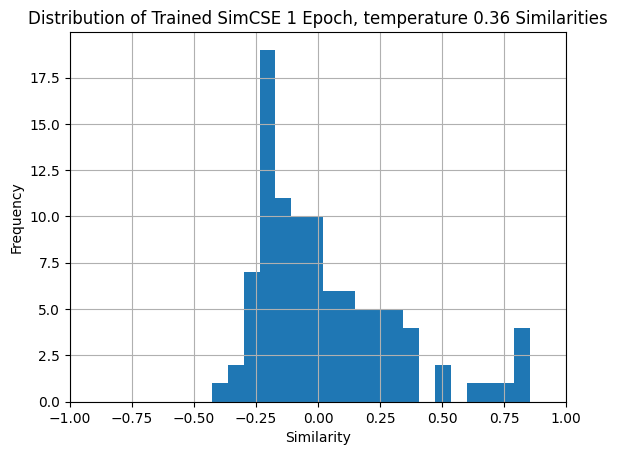

In [28]:
plt.hist(simcse_similarities, bins=20)
plt.grid()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Trained SimCSE 1 Epoch, temperature 0.36 Similarities')
plt.xlim(-1,1)
plt.show()